In [1]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1,28,28,1)), x_test.reshape((-1,28,28,1))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)

y_train_cls = y_train.astype(np.int32)
y_test_cls = y_test.astype(np.int32) 

y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32)

print(type(x_train)) 
print(type(y_train)) 
print(type(y_train_cls)) 
print(type(x_test))  
print(type(y_test))  
print(type(y_test_cls))  

print(x_train.shape) 
print(y_train.shape) 
print(y_train_cls.shape) 
print(x_test.shape)  
print(y_test.shape)  
print(y_test_cls.shape)

print(x_train.dtype) 
print(y_train.dtype) 
print(y_train_cls.dtype) 
print(x_test.dtype)  
print(y_test.dtype)  
print(y_test_cls.dtype)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(60000, 28, 28, 1)
(60000, 10)
(60000,)
(10000, 28, 28, 1)
(10000, 10)
(10000,)
float32
float32
int32
float32
float32
int32


In [2]:
lr = 1e-3
epoch = int(2e1)
batch_size = 64

import numpy as np; np.random.seed(0)
import tensorflow.compat.v1 as tf; tf.disable_v2_behavior()
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 28, 28, 1)) # (?, 28, 28, 1)
y = tf.placeholder(tf.float32, (None, 10)) # (?, 10)
y_cls = tf.placeholder(tf.int32, (None,)) # (?,)
drop_prob = tf.placeholder(tf.float32, shape=[])

init_w = tf.keras.initializers.VarianceScaling(seed=0)
init_b = tf.keras.initializers.zeros()

w1 = tf.get_variable('w1', (5,5,1,32), tf.float32, init_w)
x1 = tf.nn.conv2d(x, w1, strides=[1,1,1,1], padding='SAME')
x1 = tf.nn.max_pool(x1, [1,2,2,1], strides=[1,2,2,1], padding='SAME')
x1 = tf.nn.relu(x1)

w2 = tf.get_variable("w2", (5,5,32,64), tf.float32, init_w)  # 51200
x2 = tf.nn.conv2d(x1, w2, strides=[1,1,1,1], padding='SAME')
x2 = tf.nn.max_pool(x2, [1,2,2,1], strides=[1,2,2,1], padding='SAME')
x2 = tf.nn.relu(x2) 
x2 = tf.reshape(x2, [-1, 3136])

w3 = tf.get_variable("w3", (3136, 100), tf.float32, init_w)  # 313600
b3 = tf.get_variable('b3', (100,), tf.float32, init_b)
x3 = tf.nn.relu(x2@w3+b3) 
x3 = tf.nn.dropout(x3, rate=drop_prob)

w4 = tf.get_variable("w4", (100, 10), tf.float32, init_w)  # 313600
b4 = tf.get_variable('b4', (10,), tf.float32, init_b)
logits = x3 @ w4 + b4
entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, 
                                                     logits=logits) # (?,)
loss = tf.reduce_mean(entropy) # ()

opt = tf.train.AdamOptimizer(lr)
train = opt.minimize(loss)

y_pred_cls = tf.cast(tf.argmax(logits, axis=1), 
                     tf.int32, name='y_pred_cls') # (?,) int32
correct_bool = tf.equal(y_pred_cls, y_cls, 
                        name='correct_bool') # (?,) bool
accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32), 
                          name='accuracy') # () float32

init = tf.global_variables_initializer()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
with tf.Session() as sess:
    
    sess.run(init)
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epoch):
        
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        
        x_epoch = x_train[idx]
        y_epoch = y_train[idx]
        y_cls_epoch = y_train_cls[idx]
        
        for k in range(x_train.shape[0]//batch_size):
            
            if k==0:
                loss_temp = []
                accuracy_temp = []
                
            x_batch = x_epoch[k*batch_size:(k+1)*batch_size]
            y_batch = y_epoch[k*batch_size:(k+1)*batch_size]
            y_cls_batch = y_cls_epoch[k*batch_size:(k+1)*batch_size]
            
            feed_dict = {x : x_batch, 
                         y : y_batch, 
                         y_cls : y_cls_batch,
                         drop_prob : 0.3}
            
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], 
                                                 feed_dict=feed_dict)
            
            loss_temp.append(loss_run) 
            accuracy_temp.append(accuracy_run)
        
        loss_avg = np.array(loss_temp).mean()
        accuracy_avg = np.array(accuracy_temp).mean()
        loss_trace.append(loss_avg)
        accuracy_trace.append(accuracy_avg)
        print(f'{i+1}/{epoch} loss {loss_avg}, accuracy {accuracy_avg} ')
    
    feed_dict = {x:x_test, 
                 y:y_test, 
                 y_cls:y_test_cls,
                 drop_prob : 0.0}
    accuracy_run, y_test_cls_pred = sess.run([accuracy, y_pred_cls], 
                                             feed_dict=feed_dict)

1/20 loss 0.17709004878997803, accuracy 0.9455209374427795 
2/20 loss 0.06095702201128006, accuracy 0.9818403124809265 
3/20 loss 0.04222695901989937, accuracy 0.9874933362007141 
4/20 loss 0.03348599746823311, accuracy 0.9893276691436768 
5/20 loss 0.027852056547999382, accuracy 0.9914621114730835 
6/20 loss 0.02295212633907795, accuracy 0.9930129647254944 
7/20 loss 0.01950233243405819, accuracy 0.9939301013946533 
8/20 loss 0.01731054298579693, accuracy 0.9946471452713013 
9/20 loss 0.013993028551340103, accuracy 0.9954975843429565 
10/20 loss 0.014417514204978943, accuracy 0.9952974915504456 
11/20 loss 0.011615453287959099, accuracy 0.9959812164306641 
12/20 loss 0.011185958981513977, accuracy 0.9961979985237122 
13/20 loss 0.010653684847056866, accuracy 0.9962646961212158 
14/20 loss 0.010295146144926548, accuracy 0.9968149662017822 
15/20 loss 0.008540555834770203, accuracy 0.9971985220909119 
16/20 loss 0.007402325049042702, accuracy 0.9974319934844971 
17/20 loss 0.00773255061

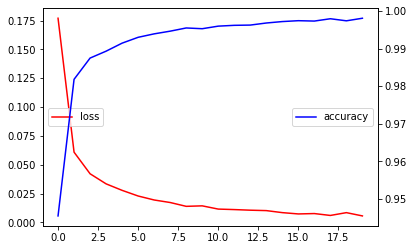

In [4]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(loss_trace, color='red', label='loss')
plt.legend(loc='center left')

ax2 = ax1.twinx() 
ax2.plot(accuracy_trace, color='blue', label='accuracy')
plt.legend(loc='center right')

plt.show()

In [5]:
print(f'Test Period Accuracy : {accuracy_run}')

Test Period Accuracy : 0.9936000108718872


In [6]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
print(cm)

[[ 977    0    0    0    0    0    2    1    0    0]
 [   0 1134    0    1    0    0    0    0    0    0]
 [   0    0 1023    0    0    0    0    7    2    0]
 [   0    0    0 1006    0    3    0    1    0    0]
 [   0    0    0    0  967    0    3    0    3    9]
 [   0    0    0    5    0  886    1    0    0    0]
 [   2    2    0    0    1    0  952    0    1    0]
 [   0    1    0    0    0    0    0 1025    1    1]
 [   1    0    2    2    0    3    0    0  963    3]
 [   0    0    0    2    1    2    0    1    0 1003]]


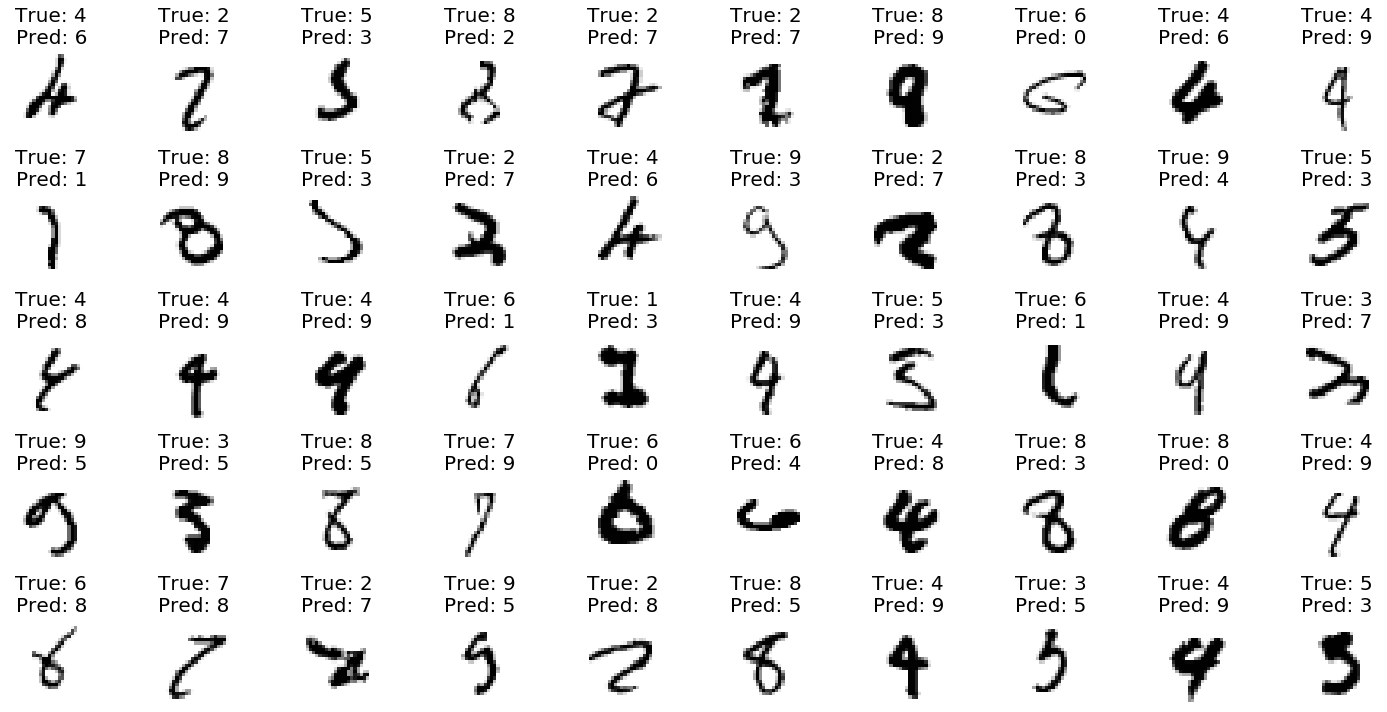

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(20,10))

idx = 0
for ax in axes.reshape((-1,)): # (2, 10) ---> (20,)
    while True:
        if y_test_cls[idx]==y_test_cls_pred[idx]:
            idx += 1
        else:
            ax.imshow(x_test[idx].reshape((28,28)), cmap='binary')
            true_label = y_test_cls[idx]
            pred_label = y_test_cls_pred[idx]
            title = f'True: {true_label}\nPred: {pred_label}'
            ax.set_title(title, fontsize=20)
            ax.axis('off')
            idx += 1
            break
            
plt.tight_layout()

plt.show()